# Template for Practical work on the Conversion of sampling frequency and STFT


*From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2020*

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
#import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write
from scipy import signal

## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
data_path = os.getcwd()
filename = '/Users/eugeniedulout/Documents/COURS/telecom 2A/TSIA1/Conversion-STFT-PW-files/caravan_48khz.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=805733, comptype='NONE', compname='not compressed')


In [56]:
play = False
if play :
    play_sound(sound) 

In [8]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [9]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

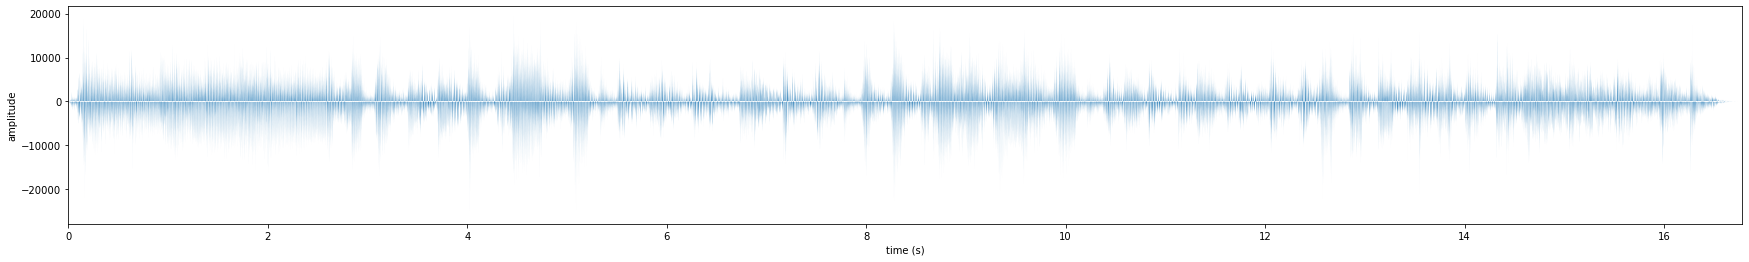

In [10]:
plot_sound(x, times)

In [12]:
write('new_caravan.wav', Fs, np.array(x, dtype=np.int16)) # to write a new wave file

## Signal analysis with the STFT

Q1

In [51]:
%%time
L=2
M=3

#X=np.fft(x)
nu_c=min(1.0/(2.0*L),1.0/(2.0*M))

##Upsampling de 2
y=[]
for a in x:
    y.append(a)
    for i in range(L-1):
        y.append(0)

##Filtrage

n=x.shape[0]
taille=20
h = signal.remez(taille,[0,nu_c,nu_c+0.02,0.5],[1,0])
xfiltre=np.convolve(x,h)

##Downsampling de 3
xfinal=[xfiltre[3*i] for i in range(len(xfiltre)//3)]

CPU times: user 742 ms, sys: 81 ms, total: 823 ms
Wall time: 888 ms


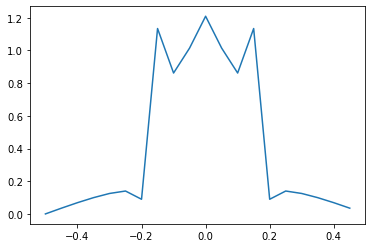

In [66]:
H=np.abs(np.fft.fft(h))

H1=H
L1=H1[0:10]
L2=H[10:20]

H=[*L2,*L1]
abs=np.arange(-taille//2,taille//2)/taille
plt.plot(abs,H)
plt.show()


Q3

In [63]:
%%time

R0=[]
for i in range(len(h)):
    if (i%2==0):
        R0.append(h[i])

R1=[]
for i in range(len(h)):
    if (i%2==1):
        R1.append(h[i])

E00=[R0[3*i] for i in range(len(R0)//3)]
E01=[R0[3*i+1] for i in range(len(R0)//3)]
E02=[R0[3*i+2] for i in range(len(R0)//3)]


E10=[R1[3*i] for i in range(len(R1)//3)]
E11=[R1[3*i+1] for i in range(len(R1)//3)]
E12=[R1[3*i+2] for i in range(len(R1)//3)]

L=np.arange(x.shape[0]//3)*3
x0=x[L]
#x1=[*[0],*x]
x1 = np.insert(x, 0, 0)
x1=x1[L]
x2 = np.insert(x, [0,0], 0)
x2=x2[L]

E00 = np.convolve(E00,x0)
E01 = np.convolve(E01,x1)
E02 = np.convolve(E02,x2)

E10 = np.convolve(E10,x0)
E11 = np.convolve(E11,x1)
E12 = np.convolve(E12,x2)

E0=E00+E01+E02
E1=E10+E11+E12

N0 = E0.shape[0]
E0_UP = np.zeros(N0*2)
E0_UP[np.arange(N0)*2] = E0

N1 = E1.shape[0]
E1_UP = np.zeros(N1*2)
E1_UP[np.arange(N1)*2] = E1

E0=np.insert(E0,0,0)

E1=np.append(E1,0) #Pour que E0 et E1 aient la même taille

x_polyphase=E0+E1





CPU times: user 38 ms, sys: 13.6 ms, total: 51.6 ms
Wall time: 71.8 ms


Q4

In [58]:
write('new_caravan.wav', Fs, np.array(xfinal, dtype=np.int16)) 
write('new_caravan_polyphase.wav', Fs, np.array(x_polyphase, dtype=np.int16)) 



In [61]:
filename = 'new_caravan.wav'
sound = os.path.join(data_path, filename)
wavefile = load_sound(sound)
print(wavefile.getparams())
play = False
if play :
    play_sound(sound)

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=268584, comptype='NONE', compname='not compressed')


In [62]:
filename = 'new_caravan_polyphase.wav'
sound = os.path.join(data_path, filename)
wavefile = load_sound(sound)
print(wavefile.getparams())
play = False
if play :
    play_sound(sound)

_wave_params(nchannels=1, sampwidth=2, framerate=48000, nframes=268580, comptype='NONE', compname='not compressed')


La reconstruction polyphase donne le même résultat que la méthode classique, avec un temps 14x plus court. Cette méthode est donc beaucoup plus intéressante.

Q2.1


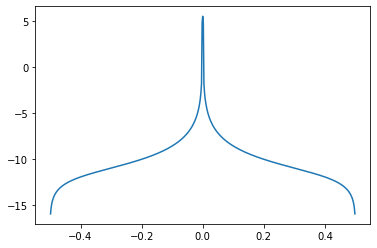

In [75]:
Nw=512
w=np.hanning(Nw)
M=512
W_tilda=np.abs(np.fft.fft(w,M)) #on calcule la TFD grace à np.fft.fft
W1=W_tilda[M//2:M]
W2=W_tilda[0:M//2]
W_tilda=[*W1,*W2] #on recentre le pic au milieu
W_tilda=np.log(W_tilda)#on passe au log pour mieux afficher 

axe= np.arange(-0.5,0.5,1/M)
plt.plot(axe,W_tilda)

Q2.2

On remaque que l'implémentation correspondant est la 2ème car l'incrément est de +uR sur les temps d'analyse, ce qui correspond à +b, et non un décrémentation de -uR.

In [76]:
N=x.shape[0]
R=1
Nt = np.rint((N - Nw) / R) # calcul du nombre de tfd à calculer
Nt = Nt.astype(int)
y = np.zeros((N,1)) # signal de synthèse
affich=1

if affich:
    Xtilde = np.zeros((M,Nt),dtype=complex)

for u in np.arange(0,Nt).reshape(-1): # boucle sur les trames
    deb = u * R + 1 # début de trame
    fin = deb + Nw # fin de trame
    tx = np.multiply(x[np.arange(deb.astype(int),fin.astype(int))],w) # calcul de la trame 
    X = np.fft.fft(tx,M) # tfd à l'instant b
    if affich:
        Xtilde[:,u] = X
    # opérations de transformation (sur la partie \nu > 0)
    # ....
    Y = X.copy
    # fin des opérations de transformation
    # resynthèse
    # overlap add

def extents(f):
  delta = f[1] - f[0]
  return [f[0] - delta/2, f[-1] + delta/2]

xk=Xtilde[2,:]
print(xk)

[6.60481429e+03-3.24065537e+03j 6.71458789e+03-3.09520440e+03j
 6.82083803e+03-2.94639927e+03j ... 2.28213873e+00+5.98599536e-01j
 2.24260112e+00+6.84304926e-01j 2.20090184e+00+7.68443332e-01j]


xk est complexe

## Overlap-add reconstruction

In [37]:
def ola(w = None,hop = None,Nb = 10): 
# function output = ola(w,hop,Nb)
# realise l'addition-recouvrement de la fenetre w,
# avec un décalage hop et un nombre Nb de fenetres.
# par defaut Nb = 10;
    
    w = w[:, np.newaxis]
    N = len(w)
    output = np.zeros(((Nb - 1) * hop + N,1)) # réserve l'espace memoire
    
    for k in np.arange(0,Nb).reshape(-1):
        deb = k* hop
        fin = deb + N
        output[np.arange(deb,fin)] = output[np.arange(deb,fin)] + w # OLA
    
    return output